In [24]:
!pip install -q imdb-sqlite

In [25]:
!pip install -q pycountry

In [2]:
import re
import time
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plp
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [18]:
%%time
!imdb-sqlite

CPU times: total: 31.2 ms
Wall time: 461 ms


2022-09-07 19:28:38,679 DB already exists: (imdb.db). Refusing to modify. Exiting


In [3]:
import sqlite3
conn = sqlite3.connect("imdb.db")

In [4]:

tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [5]:
type(tabelas)

pandas.core.frame.DataFrame

In [6]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [7]:
tabelas = tabelas["Table_Name"].values.tolist()

In [8]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("-" *100)
    print("\n")

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




In [9]:
consulta1 = "SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type"

In [10]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [11]:
#Categorias de filmes mais comuns
display(resultado1)

,type,COUNT
0,movie,620496
1,short,887961
2,tvEpisode,6939038
3,tvMiniSeries,45002
4,tvMovie,137486
5,tvPilot,2
6,tvSeries,230613
7,tvShort,10658
8,tvSpecial,38189
9,video,265004


In [12]:
#% de filmes mais comuns
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [13]:
display(resultado1)

,type,COUNT,percentual
0,movie,620496,6.739723
1,short,887961,9.644883
2,tvEpisode,6939038,75.370665
3,tvMiniSeries,45002,0.488804
4,tvMovie,137486,1.493350
5,tvPilot,2,0.000022
6,tvSeries,230613,2.504880
7,tvShort,10658,0.115765
8,tvSpecial,38189,0.414803
9,video,265004,2.878429


In [14]:
#GRAFICO com as 3 principais categorias + o restante

others = {}
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()
others['type'] = 'others'


In [15]:
others

{'COUNT': 759055, 'percentual': 8.244727938261345, 'type': 'others'}

In [16]:
resultado1 = resultado1[resultado1['percentual']>5]

In [17]:
resultado1 = resultado1.append(others, ignore_index = True)

In [18]:
#ORDENAR
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [19]:
#Grafico
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6939038,75.370665
1,short,887961,9.644883
3,others,759055,8.244728
0,movie,620496,6.739723


In [20]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

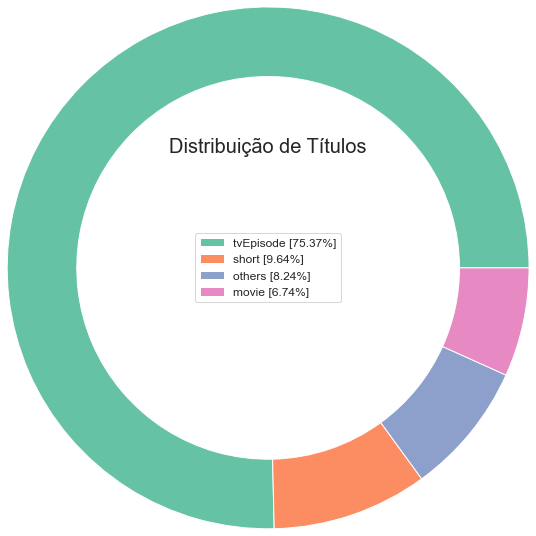

In [21]:
from matplotlib import pyplot as plt
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set2(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

In [22]:
consulta2 = "SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres"

In [23]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [24]:
display(resultado2)

,genres,COUNT(*)
0,Action,14177
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1463,"Thriller,Western",43
1464,War,1313
1465,"War,Western",14
1466,Western,5144


In [25]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [26]:
temp = resultado2['genres'].dropna()

In [27]:
type(temp)

pandas.core.series.Series

In [29]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [30]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [31]:
bag_generos = vetor.transform(temp)

In [32]:
type(bag_generos)

scipy.sparse._csr.csr_matrix

In [33]:
generos_unicos = vetor.get_feature_names()

In [34]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [35]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [36]:
generos = generos.drop(columns = 'n', axis = 0)

In [37]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [38]:
generos_percentual.head(10)

drama          17.915531
comedy         16.961853
documentary    15.871935
adventure      14.782016
action         14.373297
romance        13.283379
crime          13.010899
mystery        12.397820
thriller       12.261580
horror         12.261580
dtype: float64

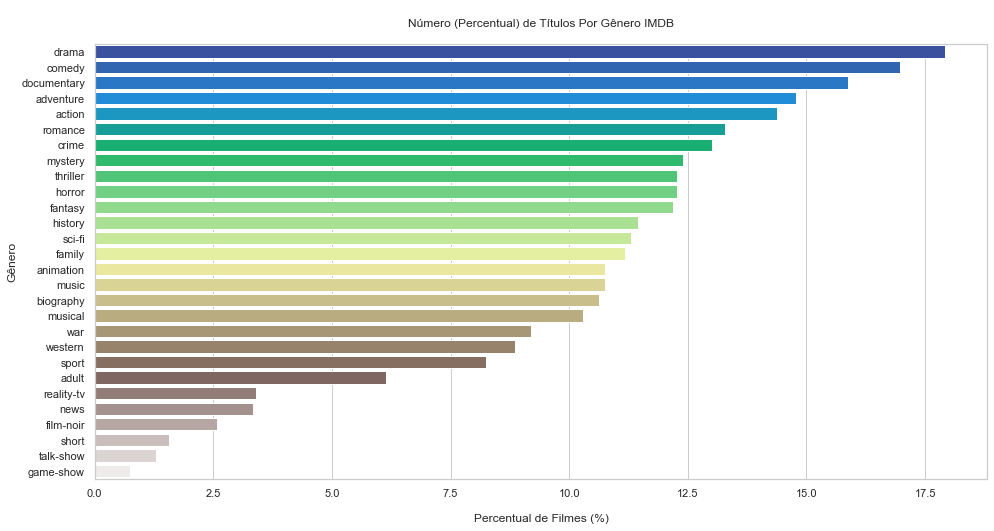

In [43]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero IMDB\n')
plt.show()

In [44]:
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [45]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [46]:
display(resultado3)

,rating,genres
0,5.2,Romance
1,3.7,\N
2,6.0,"Action,Adventure,Biography"
3,4.0,Drama
4,4.1,Drama
...,...,...
281856,5.8,Thriller
281857,6.4,"Drama,History"
281858,3.8,"Adventure,History,War"
281859,8.3,Drama


In [47]:
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [48]:
generos_unicos = retorna_generos(resultado3)

In [49]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [50]:
genero_counts = []
genero_ratings = []

In [51]:
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [52]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [53]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,29209,5.8
1,adult,4403,5.8
2,adventure,17673,6.0
3,animation,4841,6.6
4,biography,8610,7.0
5,comedy,69572,6.0
6,crime,24113,6.1
7,documentary,42419,7.3
8,drama,124853,6.3
9,family,10861,6.3


In [54]:
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [55]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

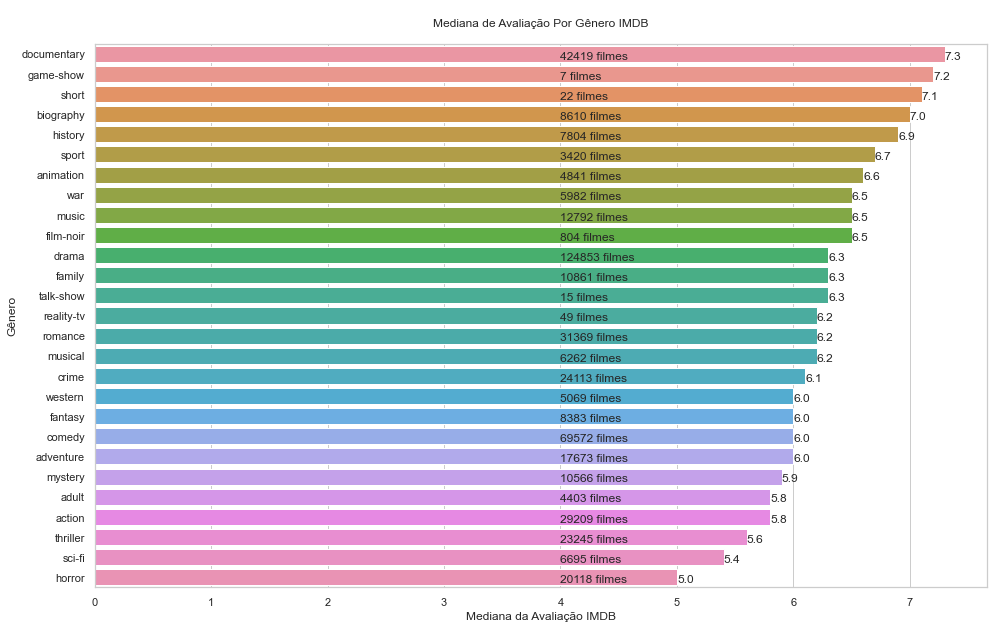

In [56]:
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação IMDB')
plt.title('\nMediana de Avaliação Por Gênero IMDB\n')
plt.show()

In [57]:
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [58]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [59]:
display(resultado4)

,Rating,premiered
0,5.2,1894
1,6.2,1896
2,4.4,1897
3,3.9,1899
4,3.2,1899
...,...,...
281856,7.9,2022
281857,6.8,2022
281858,5.3,2022
281859,3.9,2022


In [60]:
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [61]:
type(ratings)

list

In [62]:
ratings[1:10]

[6.2, 4.4, 3.55, 5.35, 4.1, 3.4, 4.0, 5.3, 3.8]

In [63]:
anos = list(set(resultado4['premiered']))

In [64]:
anos[1:10]

[1896, 1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905]

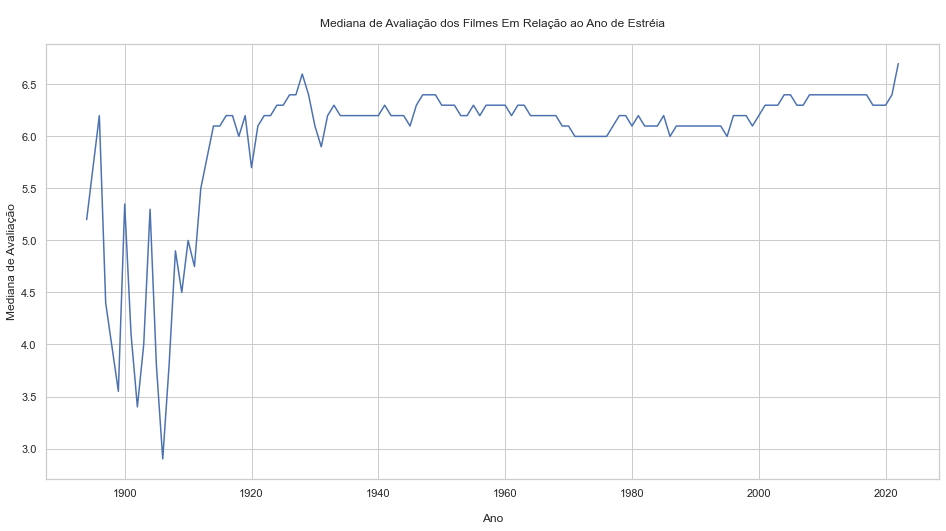

In [65]:
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

In [66]:
consulta5 = '''SELECT genres FROM titles ''' 

In [67]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [68]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9206545,"Action,Drama,Family"
9206546,"Action,Drama,Family"
9206547,"Action,Drama,Family"
9206548,Short


In [73]:
generos_unicos = retorna_generos(resultado5)

In [74]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [75]:
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [76]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [77]:
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

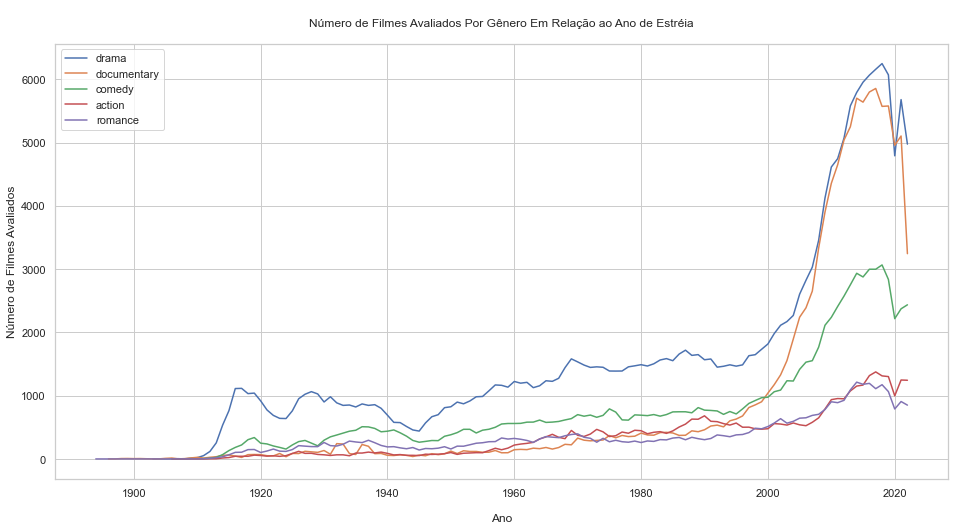

In [78]:
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

In [118]:
consulta6 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 20          
            ''' 

In [119]:
top20_melhores_filmes = pd.read_sql_query(consulta6, conn)

In [120]:
display(top20_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0
